In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import json
import sys
import re
import logging
import os
import re
from pathlib import Path
from functools import partial, cache, cached_property
from itertools import chain
from uuid import uuid4

import blpapi
import ipywidgets as w
import ipyvuetify as v
import numpy as np
import pandas as pd
import QuantLib as ql
from IPython.display import display
from ipydatagrid import DataGrid, TextRenderer, BarRenderer, Expr, VegaExpr
from bqplot import LinearScale, ColorScale, OrdinalColorScale, OrdinalScale
from pandas.tseries.offsets import BDay
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
# from bhsysapi import BHSysApi

from api.data.base import data_path, radar_path
from api.gui.params import bbg_params, spot_params, fwd_params
from api.instruments.swap import RealSwap, RollingSwap, Fly, Spread
from api.instruments.utils import parse_dates, parse_number, ez_bump
from api.instruments.future import FutureChain, FutureSpread, FutureFly
from api.gui.theme import bg_color, grid_style
from api.gui.pandas import DFOutput, negative_red, custom_styler_row_line, DataGridGio

from gioutils import ezutils as ez
from gioutils.ezutils import bh, bhs
from gioutils.blpw import BlpQuery
from gioutils.gui.pandas import millify
from gioutils.utils import (
    RepeatedTimer, 
    parse_swap_tenor_expr, 
    parse_offset,
    today, 
    get_next_n, 
    get_n_from_code,
    date_from_offset, 
    get_bday,
    get_bbg_fut_chain_ticker
)

from techi import api as ti

In [8]:
pd.options.plotting.backend = "plotly"
pd.options.display.float_format = millify

In [9]:
bq = BlpQuery(timeout=50000).start()
# ba = BHSysApi(password="A&3jg5Aj")

In [16]:
[get_n_from_code(code) for code in ['m3', 'm4', 'm5']] 

[3, 7, 11]

In [17]:
hist = '6m'
legs = [get_n_from_code(code) for code in ['m3', 'm4', 'm5']] 

In [20]:
legs

[3, 7, 11]

In [19]:
fly = FutureFly.from_legs(
    ticker='ed',
    legs=legs,
    start_hist=hist
)

In [21]:
f1 = FutureChain('ed7', start_hist=hist)
# f2 = FutureChain('ed9', start_hist=hist)

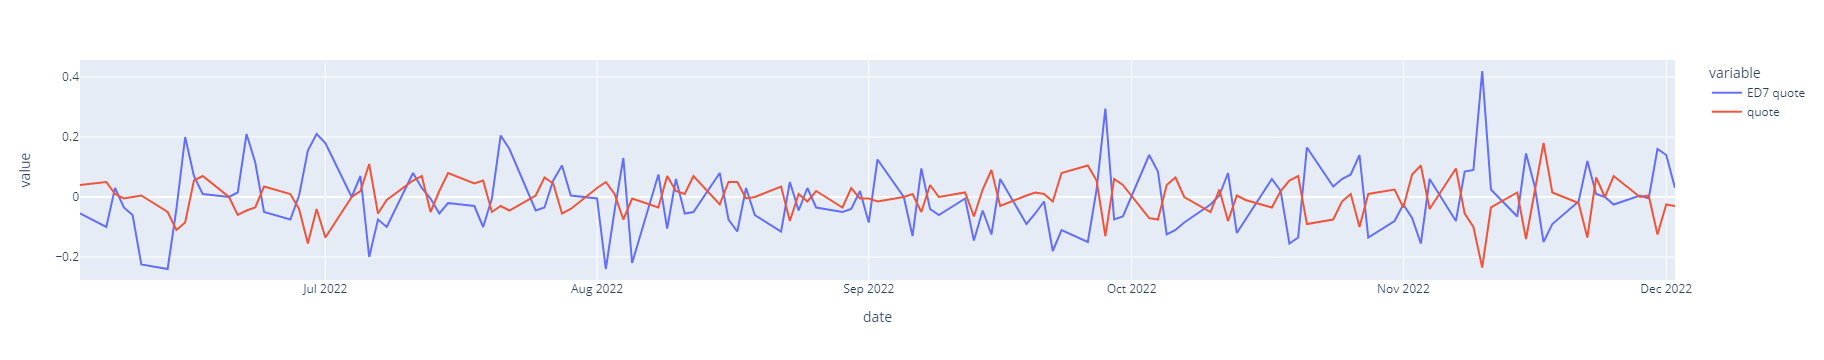

In [47]:
df_reg.plot()

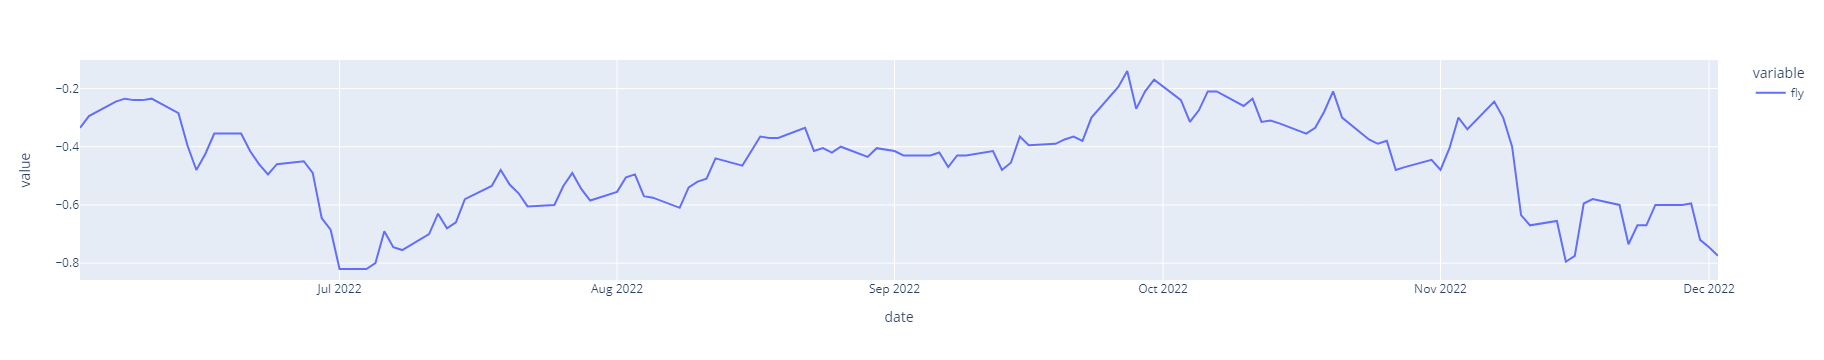

In [24]:
fly.quote.rename('fly').plot()

In [26]:
def get_df_reg(X, y, diff=False, history=None):
    if diff:
        X = X.diff().dropna()
        y = y.diff().dropna()
    if history:
        X = X.loc[X.index[-1] - parse_offset(history):, :]
        y = y.loc[y.index[-1] - parse_offset(history):]
    df_reg = pd.concat([X, y], axis=1).ffill()
    return df_reg

In [27]:
df_reg = get_df_reg(
    X=f1.quote.to_frame(), 
    y=fly.quote,
    diff=True,
    history='6m'
)

In [28]:
lm = LinearRegression(fit_intercept=False)
lm.fit(df_reg.iloc[:, :-1], df_reg.iloc[:, -1]);

In [29]:
y_pred = pd.Series(lm.predict(df_reg.iloc[:, :-1]), index=df_reg.iloc[:, :-1].index, name='pred')

In [30]:
c = lm.coef_[0]
# c = 0.15

In [31]:
c

-0.3695694211679603

In [46]:
s1 = (fly.quote - c * f1.quote).rename('hedge')
s1 = s1 - s1.iloc[0]

s2 = fly.quote.rename('fly')
s2 = s2 - s2.iloc[0]

s3 = f1.quote
s3 = s3 - s3.iloc[0]

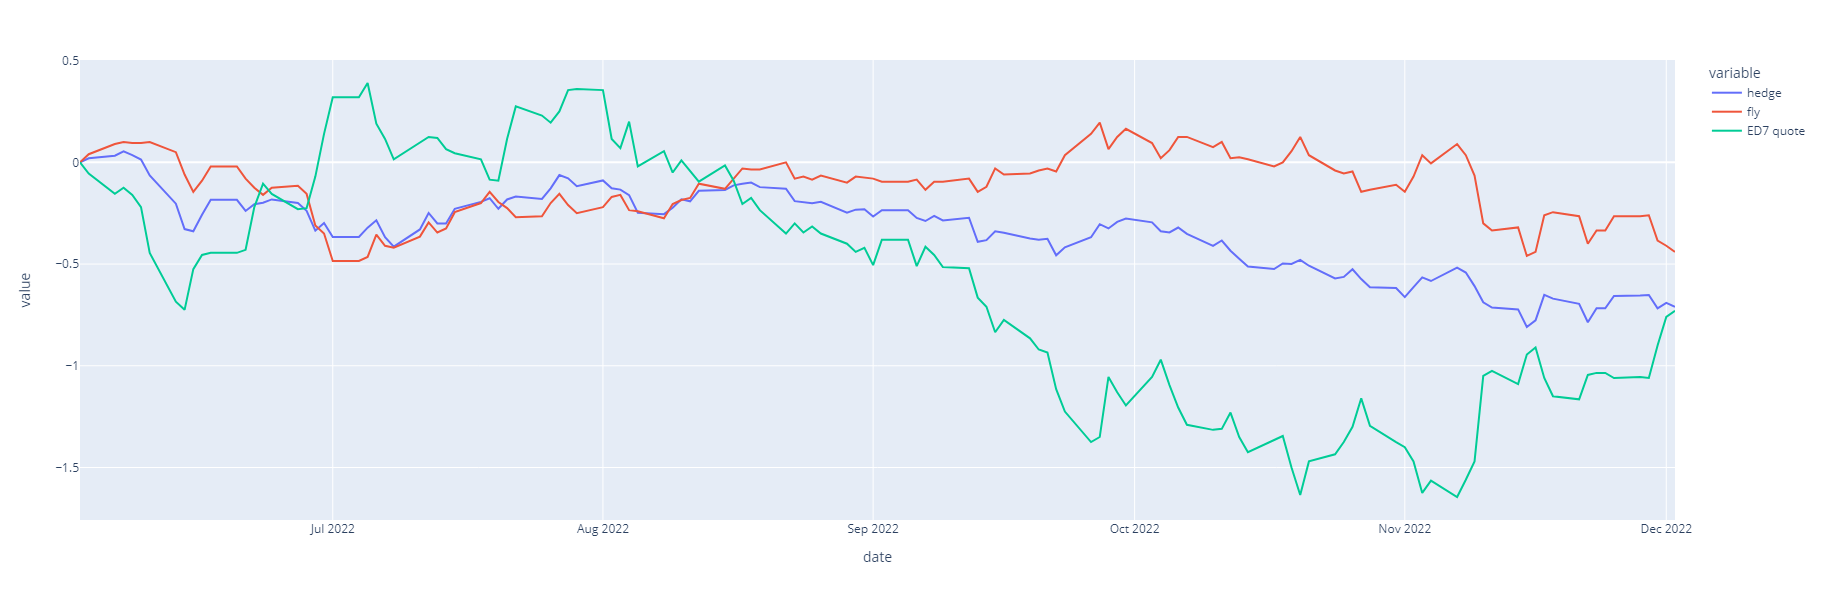

In [39]:
pd.concat([s1, s2, s3], axis=1).plot(height=600)

In [39]:
(lm.coef_[0] * f2.quote).diff().mean()

0.0010039596067036567

In [41]:
fly.quote.diff().mean()

-0.004198473282442727

In [ ]:
fly = - 0.15

In [32]:
f"params: {lm.coef_}, intercept: {lm.intercept_}, r2: {lm.score(df_reg.iloc[:, :-1], df_reg.iloc[:, -1])}"

'params: [-0.36956942], intercept: 0.0, r2: 0.42514720827535646'

In [13]:
fly.quote

date
2022-05-16   -16.500%
2022-05-17   -14.000%
2022-05-18   -12.500%
2022-05-19   -21.000%
2022-05-20   -25.500%
               ...   
2022-11-09   -52.500%
2022-11-10   -59.000%
2022-11-11   -66.000%
2022-11-14   -67.000%
2022-11-15   -71.500%
Length: 132, dtype: float64

In [ ]:
from 

In [6]:
self = FutureChain('ty1', notional='d250', bq=bq)

In [7]:
components = [
    FutureChain('ed1', notional=1),
    FutureChain('ed3', notional=-1)
]

In [8]:
ff = FutureFly.from_legs(
    ticker='ed',
    legs=[2, 6, 10],
    notional=1000
)

In [9]:
class Strategy:
    def __init__(
        self, 
        instrument,
    ):
        self.instrument = instrument

In [10]:
def  get_crossover_signal(line):
    return (-np.sign(line * line.shift()).replace(1, np.nan) * np.sign(line)).ffill()

In [11]:
def wait_for_confirmation(signal, wait=3):
    s = signal
    groups = []
    grouper = s.diff().abs().cumsum().fillna(0)
    for index, group in s.groupby(grouper, sort=False):
        group_abs = group.abs()
        if group_abs.sum() < wait:
            group.loc[~group.isna()] = 0
        else:
            idx = (group_abs.cumsum() == wait).idxmax()
            group.loc[(group_abs.index < idx) & (~group.isna())] = np.nan
        groups.append(group)

    ns = pd.concat(groups)
    return ns

In [12]:
class BaseSignal:
    def __init__(self, **kwargs):
        self.wait = kwargs.pop('wait', False)
    
    @property
    @cache
    def signal(self):
        s = self._get_signal()
        return self.post(s)
        
    def post(self, signal):
        if w:= self.wait:
            signal = wait_for_confirmation(signal, w)
        return signal

In [13]:
class MACDSignal(BaseSignal):
    _fn = 'MACD'
    _line = 'macdhist'
    def __init__(
        self, 
        instrument,
        ti_kwargs=None,
        **kwargs
    ):
        self.instrument = instrument
        self.ti_kwargs = ti_kwargs or None
        super().__init__(**kwargs)
        
    def _get_signal(self):
        fn = getattr(ti, self._fn)
        instr = self.instrument
        line = fn(instr.quote)[self._line]
        s = get_crossover_signal(line)
        return s

In [ ]:
ms.instrument.pv.diff().to_clipboard()

In [ ]:
ms = MACDSignal(ff)

In [ ]:
ms.signal.to_clipboard()

In [ ]:
ms.signal.fillna(0).diff().to_clipboard()

In [ ]:
ms.signal.fillna(0).diff() * 

In [ ]:
f = FutureChain('ty1')

In [ ]:
f.tick_value * f.notional

In [15]:
FutureChain('tu1').tick_value

7.8125

In [22]:
_.to_clipboard()

In [23]:
FutureChain('ty1').quote

date
2021-11-15   128.91
2021-11-16   128.78
2021-11-17   129.06
2021-11-18   129.19
2021-11-19   129.48
              ...  
2022-11-09   110.33
2022-11-10   112.52
2022-11-11   112.31
2022-11-14   112.12
2022-11-15   112.59
Name: TY1 quote, Length: 262, dtype: float64

In [20]:
FutureChain('tu1').tick_size

0.00390625

In [18]:
FutureChain('tu1').point_value / 100

20.0

In [19]:
FutureChain('ty1').point_value / 100

10.0

In [ ]:
t = ba.getTable(
    namespace="BH_Query", 
    table="query_cont_bars", 
    symbol="EDc1", 
    bar_size="1day", 
    start_date=pd.to_datetime("2022-08-01"),
    roll_adjustment='multiplicative'
)

In [ ]:
catalog = ba.getCatalog()

In [ ]:
catalog

In [ ]:
ba.getTable("BH_SecMaster_Futures", 'roll_offset_mapping').to_clipboard()

In [ ]:
d = _

In [ ]:
d.loc[d['description'].str.contains('SOFR')]

In [ ]:
ba.getTable("BH_SecMaster_Futures", 'main', ticker='SFRU3')

In [ ]:
ba.getTable("BH_SecMaster_Futures", 'main', sector_sub_type='Index', rec_type='FUTURE')

In [ ]:
d = _

In [ ]:
s.trade

In [ ]:
trace1 = s1.pv.plot()

In [ ]:
trace1

In [ ]:
trace2 = swap_rate.plot()

In [ ]:
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    trace1.data[0],
    secondary_y=False,
)

fig.add_trace(
    trace2.data[0],
    secondary_y=True,
)